In [1]:
import pandas as pd

df = pd.read_csv('patient_data.csv')

In [2]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title='Profiling Report', minimal=True)
# profile.to_file("data_profile.html")

In [3]:
from preprocessing import preprocess_data

df = preprocess_data(df)

In [4]:
df.head()

,female,age,hosplos,iculos,apache2,ADMITLOCATIONTXT,PrimaryDiagnosis,INITIALADMIT,Overflow,Mechanical.Ventilation,vasoactive,Oncatheter,OnInsulin,readmit72
0,0.0,42.0,4357260.0,763920.0,24.333333,4.0,275.0,1.0,0.0,1.0,1.0,0.0,1.0,False
1,1.0,61.0,4215360.0,649800.0,14.000000,3.0,143.0,1.0,1.0,1.0,1.0,0.0,1.0,True
2,1.0,61.0,4215360.0,246300.0,19.000000,13.0,294.0,0.0,1.0,1.0,1.0,1.0,1.0,True
3,1.0,61.0,4215360.0,361140.0,18.000000,0.0,254.0,0.0,0.0,1.0,0.0,1.0,0.0,False
4,0.0,68.0,1995120.0,159780.0,13.000000,0.0,271.0,1.0,1.0,1.0,0.0,1.0,0.0,False


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(columns='readmit72')
y = df['readmit72']

# Identify indices of all positive and negative samples
positive_indices = np.where(y.values == 1)[0]
negative_indices = np.where(y.values == 0)[0]

# Sample negative indices to match the number of positive samples
sampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=True)

# Combine and shuffle indices
sampled_indices = np.concatenate([positive_indices, sampled_negative_indices])
np.random.shuffle(sampled_indices)

# Select sampled data from the original dataset
X = X.values[sampled_indices]
y = y.values[sampled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

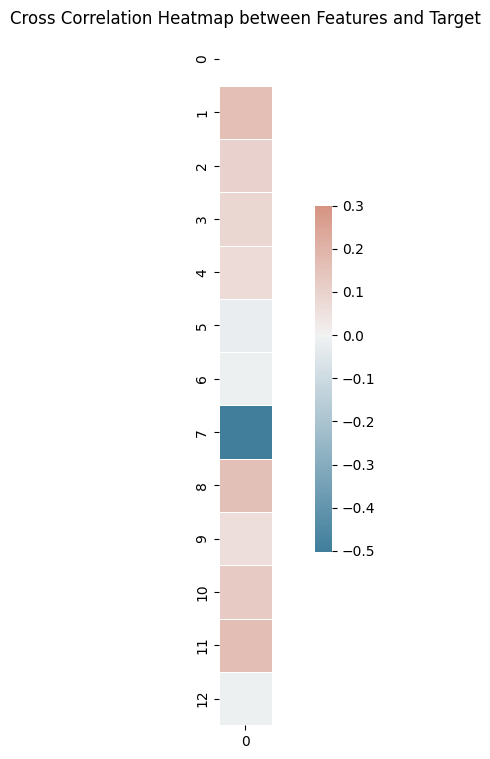

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = np.corrcoef(X.T, y)[0:X.shape[1], X.shape[1]:]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Cross Correlation Heatmap between Features and Target')
plt.show()

In [7]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert DataFrame to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor.view(-1, 1))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=19, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=19, persistent_workers=True)

In [8]:
from MLP import MLP
import pytorch_lightning as pl

model = MLP()
trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 896   
1 | fc2  | Linear | 8.3 K 
2 | fc3  | Linear | 8.3 K 
3 | fc4  | Linear | 2.1 K 
4 | fc5  | Linear | 33    
--------------------------------
19.6 K    Trainable params
0         Non-trainable params
19.6 K    Total params
0.078     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.450549453496933     │
│         test_loss         │    0.6594354510307312     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6594354510307312, 'test_accuracy': 0.450549453496933}]

In [9]:
from KAN import KAN
import pytorch_lightning as pl

model = KAN()
trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | kan1 | KANLayer | 3.5 K 
1 | kan2 | KANLayer | 8.7 K 
2 | kan3 | KANLayer | 8.7 K 
3 | fc1  | Linear   | 136   
4 | fc2  | Linear   | 9     
----------------------------------
12.5 K    Trainable params
8.6 K     Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.45054945054945056    │
│         test_loss         │    0.6962806484201453     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6962806484201453, 'test_accuracy': 0.45054945054945056}]

In [10]:
# from kan import KAN

# model = KAN(width=[13, 1], grid=20, k=3)

# dataset = {
#     'train_input': X_train_tensor,
#     'train_label': y_train_tensor.view(-1, 1),
#     'test_input': X_test_tensor,
#     'test_label': y_test_tensor.view(-1, 1)
# }

# def train_precision():
#     predictions = torch.round(model(dataset['train_input'])[:,0])
#     correct_predictions = predictions == dataset['train_label'][:,0]
#     precision = torch.sum(correct_predictions.float()) / (torch.sum(predictions) + 1e-8)
#     return precision

# def test_precision():
#     predictions = torch.round(model(dataset['test_input'])[:,0])
#     correct_predictions = predictions == dataset['test_label'][:,0]
#     precision = torch.sum(correct_predictions.float()) / (torch.sum(predictions) + 1e-8)
#     return precision

# results = model.train(dataset, opt="ADAM", steps=30, metrics=(train_precision, test_precision));
# results['train_precision'][-1], results['test_precision'][-1]

In [11]:
# model.plot(beta=100, scale=1.05)

In [12]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
# model.auto_symbolic(lib=lib)

In [13]:
# formula = model.symbolic_formula()[0][0]
# formula

In [14]:
# import numpy as np

# # Test formula accuracy
# def acc(formula, X, y):
#     batch = X.shape[0]
#     correct = 0
#     for i in range(batch):
#         logit = np.round(np.array(formula.subs('x_1', X[i,0])
#                          .subs('x_2', X[i,1])
#                          .subs('x_3', X[i,2])
#                          .subs('x_4', X[i,3])
#                          .subs('x_5', X[i,4])
#                          .subs('x_6', X[i,5])
#                          .subs('x_7', X[i,6])
#                          .subs('x_8', X[i,7])
#                          .subs('x_9', X[i,8])
#                          .subs('x_10', X[i,9])).astype(np.float64))
#         correct += logit == y[i]
#     return correct/batch

# print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
# print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))